In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

%cd "./drive/My Drive/Colab Notebooks/neural-learning"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/neural-learning


In [6]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import copy
import numpy as np
from scipy.signal import find_peaks
import scipy.fftpack
from matplotlib import pyplot as plt
import seaborn as sns
import time

from src.network import Layer, PropogationNetwork, FullyConnectedLayerApprox
from src.ou_process import ouprocess_gaussian
from src.experiment import Experiment, MultiVariableExperiment

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
NUM_NEURONS = 200
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 30.0e3

RESULTS_DIR = "./results"
GRAPHS_DIR = "./graphs"

In [0]:
# Slow Signal: INPUT
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

In [8]:
LOAD_LAYER = True
load_layer_file = "poc1a__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"

test_t_stop = 5000.0

if LOAD_LAYER:
    experiment = Experiment.load(RESULTS_DIR, load_layer_file)
    layer = experiment.layer
else:
    layer = Layer(NUM_NEURONS)
    layer.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)

start_time = time.time()
out, V, F_binary, F_synaptic = layer.output(i_inj, dt, t_stop)
print(time.time() - start_time)

vectorized


ValueError: ignored

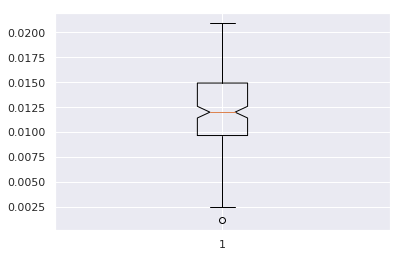

In [8]:
plt.boxplot(layer.W, notch=True, sym="o")
plt.show()

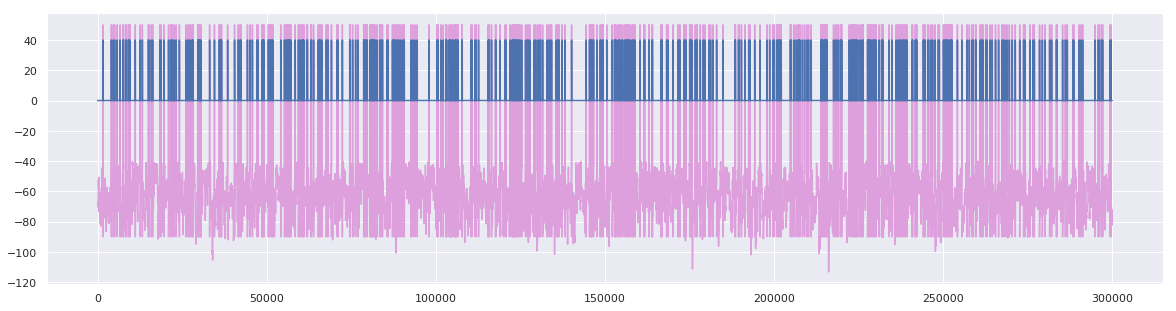

In [9]:
trial = 10
t_i = 0
t_f = -1
plt.figure(figsize=(20,5))
plt.plot(V[t_i:t_f,trial], color='plum')
plt.plot(F_binary[t_i:t_f,trial] * 40.0)
plt.show()

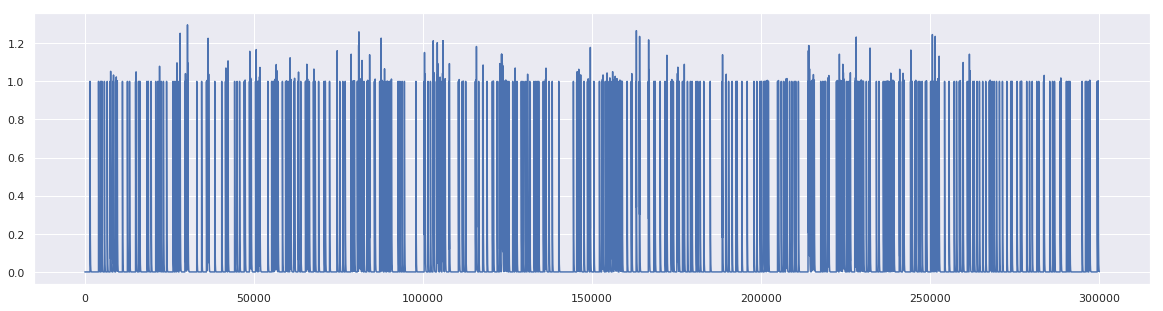

In [10]:
plt.figure(figsize=(20,5))
plt.plot(F_synaptic[:,10])
plt.show()

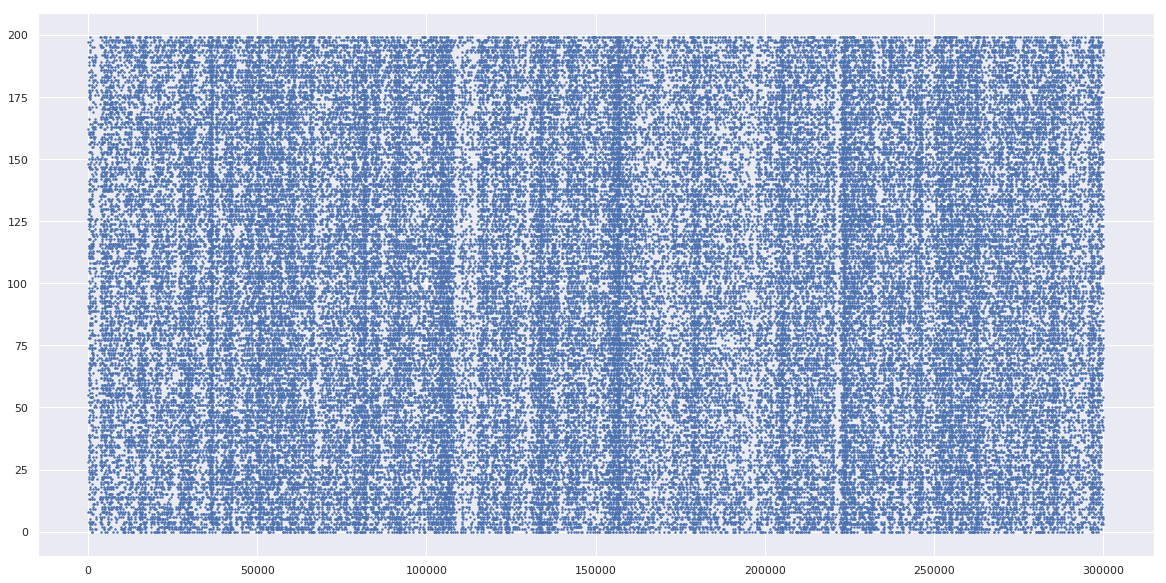

In [11]:
spike_inds, spike_trial = np.where(F_binary > 0)
plt.figure(figsize=(20,10))
plt.scatter(spike_inds, spike_trial, s=2)
plt.show()

In [12]:
a = np.where(F_binary[:,10] > 0)[0]
a.shape

(449,)

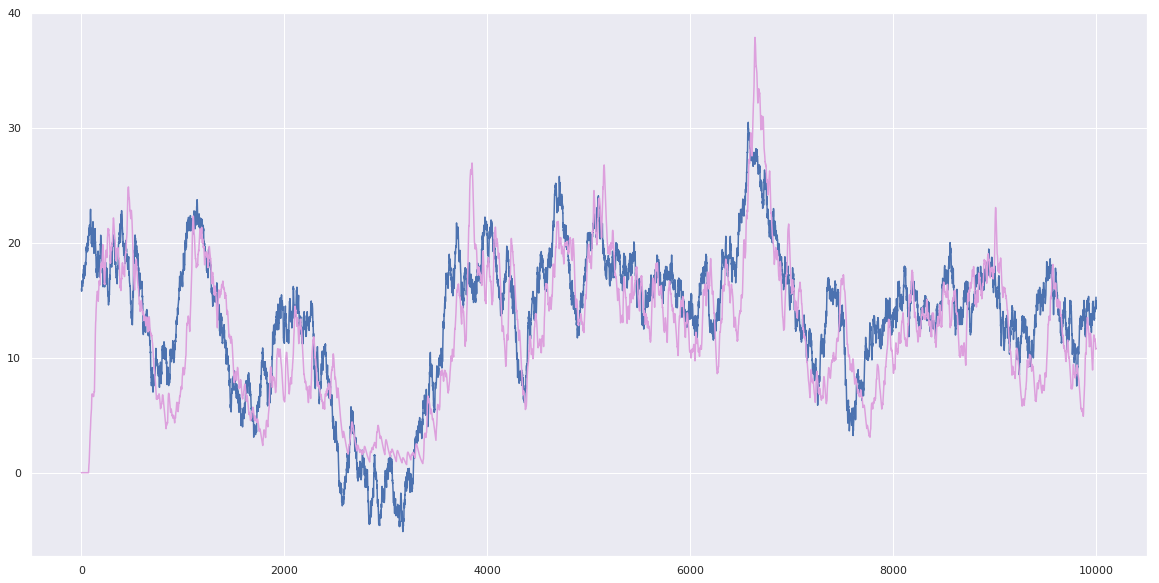

In [13]:
plt.figure(figsize=(20,10))
plt.plot(i_inj[:10000])
plt.plot(out[:10000], 'plum')
plt.show()

In [14]:
np.linalg.norm(out-i_inj)

2139.62044347222

### PoC 1a: Regenerate Internal Noise (Same Input)
For the SAME INPUT, can we shuffle / regenerate internal noise?

In [0]:
LOAD_POC_1A = True
load_poc_1a_file = "poc1a__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"

test_t_stop = 5000.0

if LOAD_POC_1A:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1a_file)
else:
    NUM_TRIALS = 200

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        inputs[:,i] = layer.train_input.flatten()[num_t*2:num_t*3]

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_poc_1a_file)

In [0]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

In [0]:
efficiencies.shape

(200,)

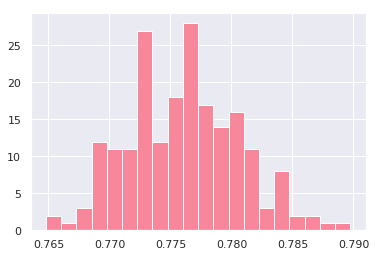

In [0]:
plt.hist(efficiencies, bins=20, color=sns.xkcd_rgb["rose pink"])
plt.show()

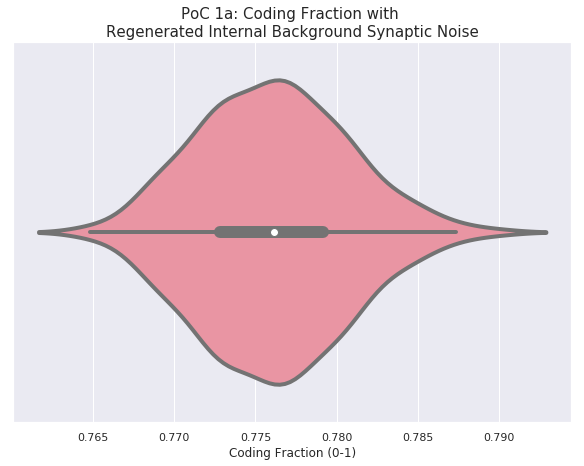

In [0]:
plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 1a: Coding Fraction with \nRegenerated Internal Background Synaptic Noise', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig((os.path.join(GRAPHS_DIR, load_poc_1a_file + ".png")))

### PoC 1b: W=N(u,sig) (Same Input)
SAME INPUT: Can we approximate weights as N(u, sig)? How does this affect reconstruction?

In [0]:
LOAD_POC_1B = True
load_poc_1b_file = "poc1b__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"

In [0]:
test_t_stop = 5000.0

if LOAD_POC_1B:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1b_file)
else:
    NUM_TRIALS = 200

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        inputs[:,i] = layer.train_input.flatten()[num_t*2:num_t*3]

    layer_shuffle = copy.deepcopy(layer)

    mean_weight = np.mean(layer_shuffle.W)
    std_weight = np.std(layer_shuffle.W)

    experiment = Experiment(inputs, layer_shuffle, NUM_TRIALS, dt, test_t_stop)

    for trial in range(NUM_TRIALS):
        experiment.layer.W = np.random.normal(mean_weight, std_weight, experiment.layer.W.shape)
        experiment.one_trial(trial, int_noise_regen=False)
    experiment.save(RESULTS_DIR, load_poc1b_file)

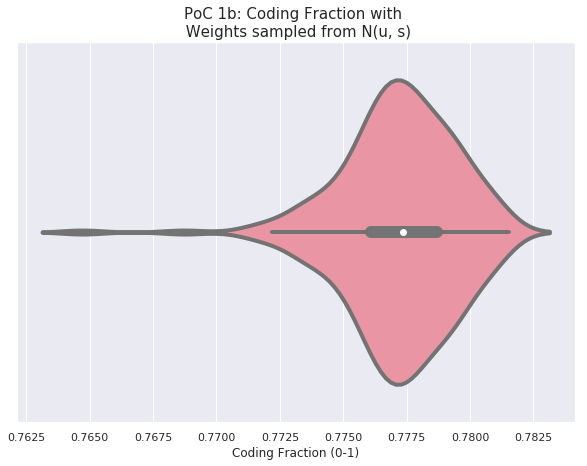

In [0]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 1b: Coding Fraction with \n Weights sampled from N(u, s)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc1b_file + ".png"))

### PoC 2a: Regenerate Internal Noise (Diff Input)
DIFFERENT INPUTS: shuffle internal noise, how does this affect reconstruction?

In [0]:
LOAD_POC_2A = True
load_poc_2a_file = "poc2a__neurons=200__trials=200__input=tau_50_regenerated__t_stop=5000_msecs"

In [0]:
if LOAD_POC_2A:
    experiment = Experiment.load(RESULTS_DIR, load_poc_2a_file)
else:
    NUM_TRIALS = 200
    test_t_stop = 5000.0

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_poc_2a_file)

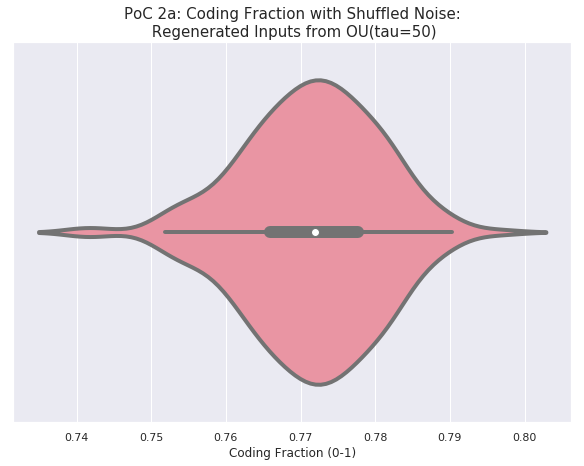

In [0]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc_2a_file + ".png"))

### PoC 2b: W=N(u,sig) (Different Input)
DIFFERENT INPUTS: shuffle weights, how does this affect reconstruction?

In [0]:
LOAD_POC_2B = True
load_poc_2b_file = "poc2b__neurons=200__trials=200__input=tau_50_regenerated__t_stop=5000_msecs"

In [0]:
if LOAD_POC_2B:
    experiment = Experiment.load(RESULTS_DIR, load_poc_2b_file)
else:
    NUM_TRIALS = 200
    test_t_stop = 5000.0

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    layer_shuffle = copy.deepcopy(layer)

    mean_weight = np.mean(layer_shuffle.W)
    std_weight = np.std(layer_shuffle.W)

    experiment = Experiment(inputs, layer_shuffle, NUM_TRIALS, dt, test_t_stop)

    for trial in range(NUM_TRIALS):
        experiment.layer.W = np.random.normal(mean_weight, std_weight, experiment.layer.W.shape)
        experiment.one_trial(trial, int_noise_regen=False)
    experiment.save(RESULTS_DIR, load_poc_2b_file)

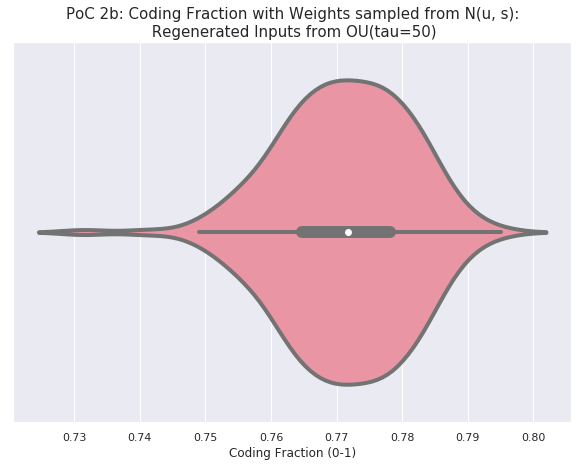

In [0]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 2b: Coding Fraction with Weights sampled from N(u, s):\n Regenerated Inputs from OU(tau=50)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

# plt.show()
plt.savefig(os.path.join(GRAPHS_DIR, load_poc_2b_file + ".png"))

### PoC 3: Biologically plausible characteristics
Find biologically plausible region of MSE(N, std) graph

noise and network size:
    network size = [20-1000, step=50 (or 100)]
    noise = [10 -- 50, step=5]

each presynaptic spike through synaptic waveform * 

In [0]:
LOAD_POC_3 = False
load_poc_3_file = "poc3__neurons={20-1000_s=500}__trials=100__input=tau_50_regenerated__t_stop=5000_msecs"

In [0]:
NUM_TRIALS = 10 # 100

NETWORK_SMALL = 20
NETWORK_LARGE = 1000
NETWORK_STEP = 500 # 50

NOISE_SMALL = 10
NOISE_LARGE = 50
NOISE_STEP = 25 #5

int_noises = range(NOISE_SMALL, NOISE_LARGE, NOISE_STEP)
network_sizes = range(NETWORK_SMALL, NETWORK_LARGE, NETWORK_STEP)
variables = {
    'int_noise': int_noises,
    'network_size': network_sizes
}

test_t_stop = 5000.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]

if LOAD_POC_3:
    mve = MultiVariableExperiment.load(RESULTS_DIR, load_poc_3_file)
else:
    inputs = np.empty((num_t, NUM_TRIALS))
    input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
    for trial in range(NUM_TRIALS):
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,trial] = i_inj.flatten()    
    
    train_input, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
    train_input = 16.0 + 6.0*train_input

    mve = MultiVariableExperiment(variables, 10, dt, test_t_stop)

    for int_noise in int_noises:
        for network_size in network_sizes:
            test_layer = Layer(network_size, std_noise=int_noise)
            test_layer.train(train_input, train_input, dt, t_stop)
            multi_values = {'int_noise': int_noise, 'network_size': network_size}
            mve.one_experiment(multi_values, inputs, layer)
    
    mve.save(RESULTS_DIR, load_poc_3_file)

/content/drive/My Drive/Colab Notebooks/neural-learning/src/network.py:84: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.W, residuals, rank, s = np.linalg.lstsq(A, exp_output)


Trial  0
10  Iter time:  0.025978803634643555
Total time:  0.02617168426513672


EXPERIMENT FINISHED:  0.11170125007629395


### Paper 1: Output voltage / current verification
Are voltage / current outputs from neurons biologically plausible?

### Paper 2: Reconstruction ability for range of taus
If we train a layer with OU(tau=a), how well can it reconstruct OU signals generated by tau={a-s, a+s}? What is an acceptable value for 's'?

In [0]:
LOAD_PAPER_2 = False
load_paper_2_file = "paper2__neurons=200__trials=200__tr_in=tau_50__test_input=tau_[35-65,5]_regenerated__t_stop=5000_msecs"

In [0]:
tau_range = range(45, 56, 5)

NUM_TRIALS = 200
test_t_stop = 5000.0

if LOAD_PAPER_2:
    experiment = Experiment.load(RESULTS_DIR, load_paper_2_file)
else:
    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS*len(tau_range)))
    
    for tau_ind in range(len(tau_range)):
        for i in range(NUM_TRIALS*tau_ind, NUM_TRIALS*(tau_ind+1)):
            tau = tau_range[tau_ind]
            input_slow, _ = ouprocess_gaussian(tau, dt, test_t_stop, 1)
            i_inj = 16.0 + 6.0*input_slow
            inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, layer, NUM_TRIALS*len(tau_range), dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_paper_2_file)

Trial  0
10  Iter time:  4.937260389328003
Total time:  4.937379837036133


Trial  10
10  Iter time:  48.89143180847168
Total time:  53.829368591308594


Trial  20
10  Iter time:  48.47922110557556
Total time:  102.3089759349823


Trial  30
10  Iter time:  48.085670471191406
Total time:  150.3952341079712


Trial  40
10  Iter time:  49.00206708908081
Total time:  199.39795684814453


Trial  50
10  Iter time:  49.366145610809326
Total time:  248.76469588279724


Trial  60
10  Iter time:  49.04033613204956
Total time:  297.8052513599396


Trial  70
10  Iter time:  48.7915403842926
Total time:  346.5979781150818


Trial  80
10  Iter time:  48.6138060092926
Total time:  395.21237993240356


Trial  90
10  Iter time:  48.91745090484619
Total time:  444.13045835494995


Trial  100
10  Iter time:  48.78198027610779
Total time:  492.9130518436432


Trial  110
10  Iter time:  48.140905141830444
Total time:  541.0546131134033


Trial  120
10  Iter time:  48.16926455497742
Total time:  589.2241814

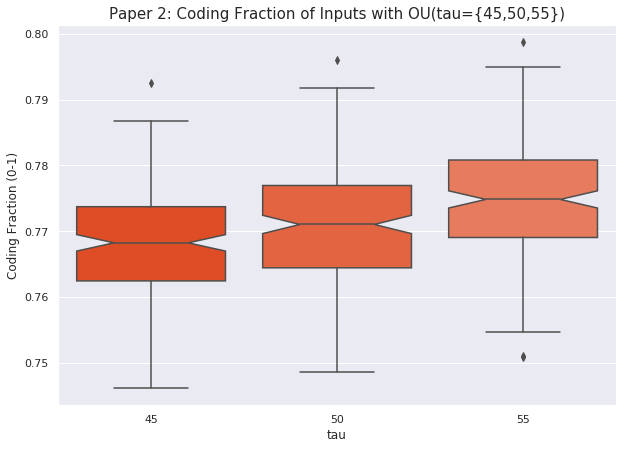

In [0]:
tau_range = list(range(45, 56, 5))
efficiencies = np.empty((len(tau_range), NUM_TRIALS))

for tau_ind in range(len(tau_range)):
    for trial in range(NUM_TRIALS):
        i = tau_ind*NUM_TRIALS + trial
        val = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])
        efficiencies[tau_ind, trial] = val

plt.figure(figsize=(10,7))

sns.boxplot(x=tau_range, y=efficiencies.tolist(), notch=True, sym="o", palette=sns.light_palette("red orange", input="xkcd", reverse=True, n_colors=8))# palette="Paired")
# sns.violinplot(efficiencies[0], linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('Paper 2: Coding Fraction of Inputs with OU(tau={45,50,55})', fontsize=15)
plt.ylabel('Coding Fraction (0-1)')
plt.xlabel('tau')

# plt.show()
plt.savefig(os.path.join(GRAPHS_DIR, load_paper_2_file + ".png"))

* how many spikes? if there is an increase in firing rate then you get more samples

### Paper 3: Multiple Layers
Can multiple layers propogate signal reliably?

In [0]:
LOAD_PAPER_3 = False
load_paper_3_file = "paper3__neurons=200__depth={1-10,1}__trials=200__tr_in=tau_50__test_input=tau_50_regenerated__t_stop=5000_msecs"

In [0]:
NUM_TRIALS = 200

DEPTH_SMALL = 1
DEPTH_LARGE = 10
DEPTH_STEP = 1

depths = range(DEPTH_SMALL, DEPTH_LARGE, DEPTH_STEP)
variables = {
    'depth': depths
}

test_t_stop = 5000.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]

if LOAD_PAPER_3:
    mve = MultiVariableExperiment.load(RESULTS_DIR, load_paper_3_file)
else:
    inputs = np.empty((num_t, NUM_TRIALS))
    input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
    for trial in range(NUM_TRIALS):
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,trial] = i_inj.flatten()

    mve = MultiVariableExperiment(variables, NUM_TRIALS, dt, test_t_stop)

    for depth in depths:
        network = PropogationNetwork.from_layer(layer, depth)
        variables = {'depth': depth}
        mve.one_experiment(variables, inputs, network)

    mve.save(RESULTS_DIR, load_paper_3_file)

Trial  0
200  Iter time:  4.404953479766846
Total time:  4.405235290527344


EXPERIMENT FINISHED:  860.1054117679596
Trial  0
200  Iter time:  8.467253684997559
Total time:  8.467544794082642


EXPERIMENT FINISHED:  1690.980064868927
Trial  0
200  Iter time:  12.686464071273804
Total time:  12.686767101287842




In [0]:
test_t_stop = 5000.0

if LOAD_PAPER_3:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1b_file)
else:
    NUM_TRIALS = 200
    NUM_LAYERS = 2
    
    network = PropogationNetwork.from_layer(layer, NUM_LAYERS)

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, network, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_paper_3_file)

Trial  0
10  Iter time:  10.065322160720825
Total time:  10.065628051757812


Trial  10
10  Iter time:  100.06873440742493
Total time:  110.13496446609497


Trial  20
10  Iter time:  100.18799448013306
Total time:  210.323340177536


Trial  30
10  Iter time:  100.00940322875977
Total time:  310.33314085006714


Trial  40
10  Iter time:  99.63653302192688
Total time:  409.97007751464844


Trial  50
10  Iter time:  99.23643970489502
Total time:  509.20741033554077


Trial  60
10  Iter time:  99.1366970539093
Total time:  608.3448956012726


Trial  70
10  Iter time:  98.94528198242188
Total time:  707.2905848026276


Trial  80
10  Iter time:  98.27120184898376
Total time:  805.562171459198


Trial  90
10  Iter time:  98.13150763511658
Total time:  903.6944510936737


Trial  100
10  Iter time:  97.56241941452026
Total time:  1001.2572741508484


Trial  110
10  Iter time:  97.98934054374695
Total time:  1099.247046470642


Trial  120
10  Iter time:  96.94126081466675
Total time:  1196.18887

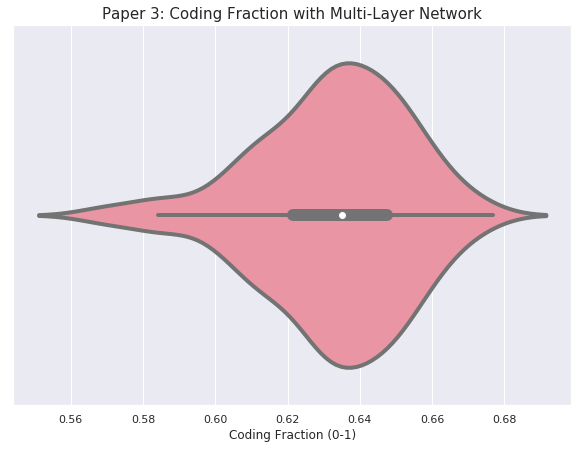

In [0]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('Paper 3: Coding Fraction with Multi-Layer Network', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

# plt.show()
plt.savefig(os.path.join(GRAPHS_DIR, load_paper_3_file + ".png"))

* plot for 2, 3, 4, 5 layers

### Paper 4: Multiple layers for range of taus
Can multiple layers propogate signal with a range of taus reliably?

### Paper 5: Generate fully connected layer
Can we generate W=(u, s) for a fully connected layer?

In [0]:
LOAD_PAPER_5 = False
load_paper_5_file = "paper5__neurons=200_fcnt__trials=200__tr_in=tau_50__test_input=tau_50_regenerated__t_stop=5000_msecs"

In [0]:
test_t_stop = 5000.0

if LOAD_PAPER_5:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1b_file)
else:
    NUM_TRIALS = 200
    NUM_LAYERS = 2
    
    network = FullyConnectedLayerApprox.from_layer(layer)

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, network, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_paper_5_file)

Trial  0
10  Iter time:  5.311272621154785
Total time:  5.311382055282593


Trial  10
10  Iter time:  53.727925539016724
Total time:  59.039695262908936


Trial  20
10  Iter time:  53.424328327178955
Total time:  112.46462035179138


Trial  30
10  Iter time:  52.91596007347107
Total time:  165.38125896453857


Trial  40
10  Iter time:  53.30431342124939
Total time:  218.6861879825592


Trial  50
10  Iter time:  53.3709921836853
Total time:  272.05792903900146


Trial  60
10  Iter time:  52.92468762397766
Total time:  324.98338985443115


Trial  70
10  Iter time:  52.7505521774292
Total time:  377.7341933250427


Trial  80
10  Iter time:  53.05578374862671
Total time:  430.79079508781433


Trial  90
10  Iter time:  53.03872776031494
Total time:  483.8299307823181


Trial  100
10  Iter time:  52.572126626968384
Total time:  536.4024450778961


Trial  110
10  Iter time:  52.46127963066101
Total time:  588.8641324043274


Trial  120
10  Iter time:  52.64685273170471
Total time:  641.511609

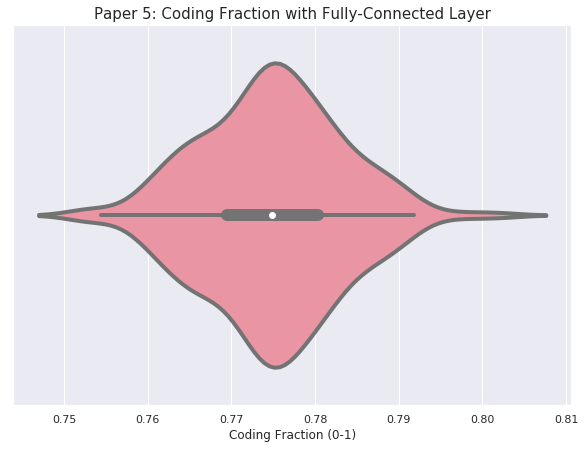

In [0]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]/experiment.layer.NUM_NEURONS-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('Paper 5: Coding Fraction with Fully-Connected Layer', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_paper_3_file + ".png"))

## EXPERIMENT
Exploratory 3b: Is the layer learning the mechanics of OU?

In [0]:
i_white = np.random.normal(0, 1, i_inj.shape) #16.0 + 6.0*
out_white, _, _, _ = layer.output(i_white, dt, t_stop)

In [0]:
i_white.shape

(200000, 1)

c:\program files\python35\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


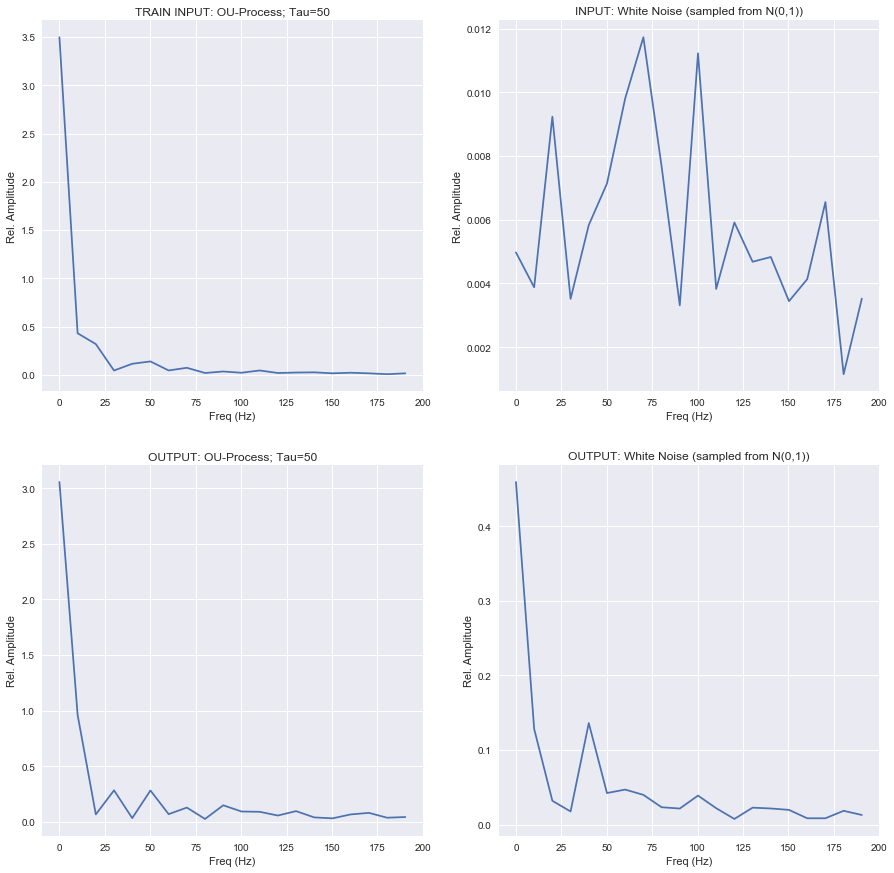

In [0]:
SAMPLE_LEN = 1000
dt_secs = dt / 1000.0
# fft_N = np.arange(0.0, SAMPLE_LEN, dt).shape[0]

i_inj_fft = scipy.fftpack.fft(i_inj[:SAMPLE_LEN, 0])
i_white_fft = scipy.fftpack.fft(i_white[:SAMPLE_LEN, 0])

ou_output_fft = scipy.fftpack.fft(out[:SAMPLE_LEN, 0])
white_output_fft = scipy.fftpack.fft(out_white[:SAMPLE_LEN, 0])

xf = np.linspace(0.0, 1.0/(2.0*dt_secs), SAMPLE_LEN/2)

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

FREQ_START = 0
FREQ_END = 20 # SAMPLE_LEN//2

axs[0, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_inj_fft[FREQ_START:FREQ_END]))
axs[0, 0].set_title('TRAIN INPUT: OU-Process; Tau=50')
axs[0, 0].set_xlabel('Freq (Hz)')
axs[0, 0].set_ylabel('Rel. Amplitude')
axs[1, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(ou_output_fft[FREQ_START:FREQ_END]))
axs[1, 0].title.set_text('OUTPUT: OU-Process; Tau=50')
axs[1, 0].set_xlabel('Freq (Hz)')
axs[1, 0].set_ylabel('Rel. Amplitude')

axs[0, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_white_fft[FREQ_START:FREQ_END]))
axs[0, 1].set_title('INPUT: White Noise (sampled from N(0,1))')
axs[0, 1].set_xlabel('Freq (Hz)')
axs[0, 1].set_ylabel('Rel. Amplitude')
axs[1, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(white_output_fft[FREQ_START:FREQ_END]))
axs[1, 1].set_title('OUTPUT: White Noise (sampled from N(0,1))')
axs[1, 1].set_xlabel('Freq (Hz)')
axs[1, 1].set_ylabel('Rel. Amplitude')

plt.show()
# plt.savefig('fft_ou_vs_white_full.png')

In [0]:
white_layer = Layer(NUM_NEURONS)
white_layer.train(i_inj=i_white, exp_output=i_white, dt=dt, t_stop=t_stop)
white_out, white_V, white_F_binary, white_F_synaptic = white_layer.output(i_inj, dt, t_stop)

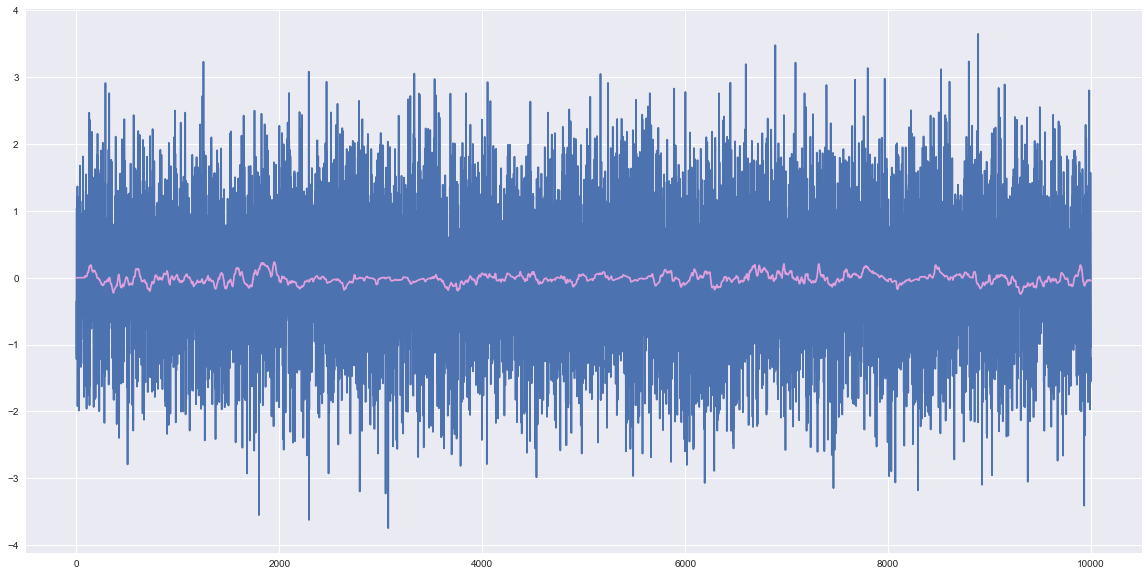

In [0]:
plt.figure(figsize=(20,10))
plt.plot(i_white[:10000])
plt.plot(white_out[:10000], 'plum')
plt.show()

In [0]:
ou_through_white, _, _, _ = white_layer.output(i_inj, dt, t_stop)

c:\program files\python35\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


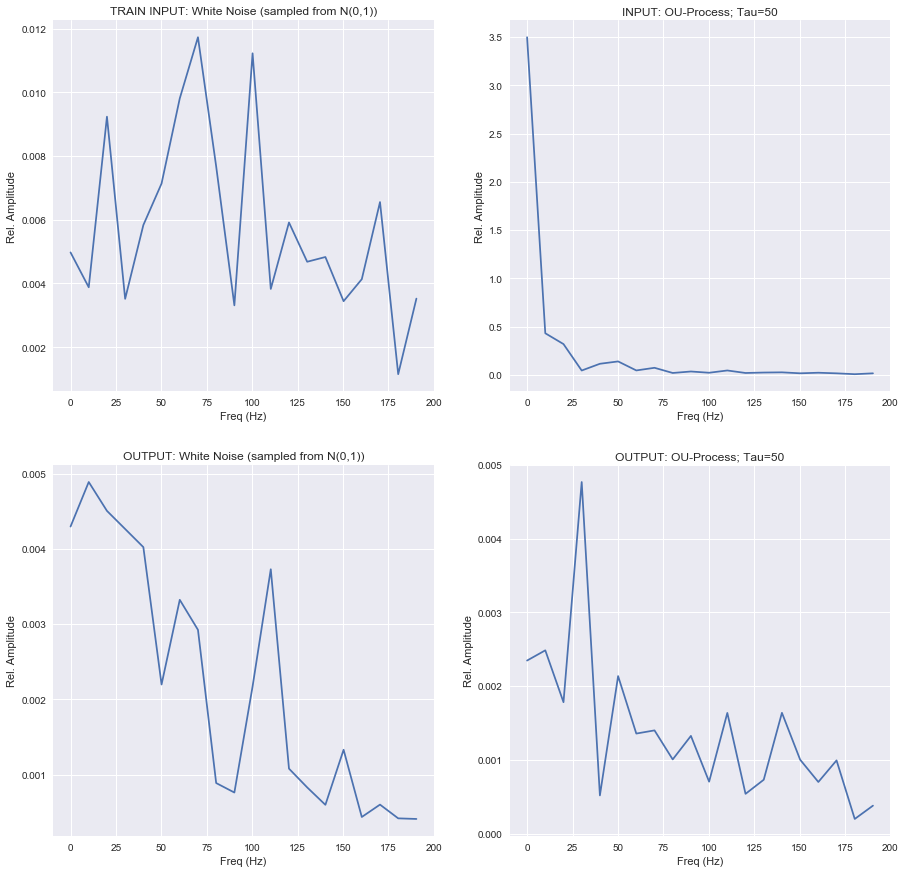

In [0]:
SAMPLE_LEN = 1000
dt_secs = dt / 1000.0
# fft_N = np.arange(0.0, SAMPLE_LEN, dt).shape[0]

i_inj_fft = scipy.fftpack.fft(i_inj[:SAMPLE_LEN, 0])
i_white_fft = scipy.fftpack.fft(i_white[:SAMPLE_LEN, 0])

ou_output_fft = scipy.fftpack.fft(ou_through_white[:SAMPLE_LEN, 0])
white_output_fft = scipy.fftpack.fft(white_out[:SAMPLE_LEN, 0])

xf = np.linspace(0.0, 1.0/(2.0*dt_secs), SAMPLE_LEN/2)

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

FREQ_START = 0
FREQ_END = 20 # SAMPLE_LEN//2

axs[0, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_white_fft[FREQ_START:FREQ_END]))
axs[0, 0].set_title('TRAIN INPUT: White Noise (sampled from N(0,1))')
axs[0, 0].set_xlabel('Freq (Hz)')
axs[0, 0].set_ylabel('Rel. Amplitude')
axs[1, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(white_output_fft[FREQ_START:FREQ_END]))
axs[1, 0].set_title('OUTPUT: White Noise (sampled from N(0,1))')
axs[1, 0].set_xlabel('Freq (Hz)')
axs[1, 0].set_ylabel('Rel. Amplitude')

axs[0, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_inj_fft[FREQ_START:FREQ_END]))
axs[0, 1].set_title('INPUT: OU-Process; Tau=50')
axs[0, 1].set_xlabel('Freq (Hz)')
axs[0, 1].set_ylabel('Rel. Amplitude')
axs[1, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(ou_output_fft[FREQ_START:FREQ_END]))
axs[1, 1].title.set_text('OUTPUT: OU-Process; Tau=50')
axs[1, 1].set_xlabel('Freq (Hz)')
axs[1, 1].set_ylabel('Rel. Amplitude')

plt.show()
# plt.savefig('fft_ou_vs_white_full.png')

### EXPERIMENT: How does amount of training data affect the weights?

In [0]:
import time

start_time = time.time()
loop_time = start_time

t_stop_var = 20.0e3

weights_v_training_t = []
training_ts = np.arange(1.0e3, 81.0e3, 10.0e3)

for t_stop_var in training_ts:
    # Slow Signal: INPUT
    input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop_var, 1)
    i_inj = 16.0 + 6.0*input_slow
    layer_var = Layer(NUM_NEURONS)
    layer_var.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop_var)
    
    weights_v_training_t += [layer_var.W]
    
    print("Training data length: ", t_stop_var)
    print("Iter time: ", time.time() - loop_time)
    print("Total time: ", time.time() - start_time)
    print("\n")
    loop_time = time.time()

Training data length:  1000.0
Iter time:  0.882685661315918
Total time:  0.882685661315918


Training data length:  11000.0
Iter time:  10.795552253723145
Total time:  11.678237915039062


Training data length:  21000.0
Iter time:  21.1056911945343
Total time:  32.783929109573364


Training data length:  31000.0
Iter time:  35.275272846221924
Total time:  68.05920195579529


Training data length:  41000.0
Iter time:  72.53712892532349
Total time:  140.9131302833557


Training data length:  51000.0
Iter time:  388.4214859008789
Total time:  529.653758764267


Training data length:  61000.0
Iter time:  615.6675934791565
Total time:  1146.6926057338715


Training data length:  71000.0
Iter time:  1406.828688621521
Total time:  2554.371639251709




In [0]:
np.savez(open(os.path.join(RESULTS_DIR, "exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.npz"), 'wb'),
            weights_v_training_t=weights_v_training_t,
            training_ts=training_ts
        )

In [0]:
exp_data = np.load(open(os.path.join(RESULTS_DIR, "exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.npz"), 'rb'))
weights_v_training_t = exp_data['weights_v_training_t'].tolist()
training_ts = exp_data['training_ts']

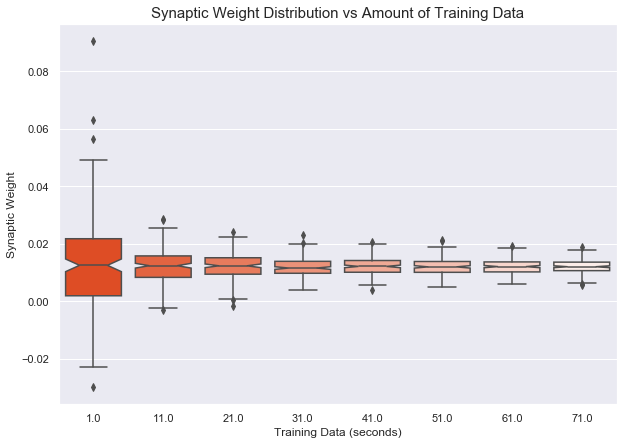

In [0]:
plt.figure(figsize=(10,7))

sns.boxplot(x=training_ts/1000.0, y=weights_v_training_t, notch=True, sym="o", palette=sns.light_palette("red orange", input="xkcd", reverse=True, n_colors=8))# palette="Paired")
plt.title('Synaptic Weight Distribution vs Amount of Training Data', fontsize=15)
plt.xlabel('Training Data (seconds)')
plt.ylabel('Synaptic Weight')

# plt.show()
plt.savefig("exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.png")

We find that the the weights center around a certain value regardless of amount of training data, but observe a decrease in standard deviation with increased training data (***Fig 3a***). This is consistent with (insert citation here) 